# Three Bays Mangrove Land Cover Classification, Artibonite, Haiti

In [107]:
import os
import gc
import json
import glob
import tarfile

import xarray as xr
import numpy as np
import pandas as pd
import earthpy.plot as ep
import rasterio as rs
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from natsort import natsorted
from datetime import datetime

Getting and sorting .tar file paths from Bulk Download Landsat Ph.D Data directory

In [49]:
data_dir = 'F:/PhD Data/Landsat 2010-2022/*.tar'
tarpaths = []
# Suffixes and Prefixes to clean to easily sort by observation date 
sfs = ['_02_T1.tar','_02_T2.tar', '_02_T1_B1.TIF', '_02_T1_B2.TIF', '_02_T1_B3.TIF', '_02_T1_B4.TIF', '_02_T1_B5.TIF', '_02_T1_MTL.json',
        '_02_T2_B1.TIF', '_02_T2_B2.TIF', '_02_T2_B3.TIF', '_02_T2_B4.TIF', '_02_T2_B5.TIF', '_02_T2_MTL.json',
        '_02_T1_SR_B1.TIF', '_02_T1_SR_B2.TIF', '_02_T1_SR_B3.TIF', '_02_T1_SR_B4.TIF', '_02_T1_SR_B5.TIF', '_02_T1_SR_B7.TIF', '_02_T1_ST_B6.TIF', '_02_T1_MTL.json',
        '_02_T2_SR_B1.TIF', '_02_T2_SR_B2.TIF', '_02_T2_SR_B3.TIF', '_02_T2_SR_B4.TIF', '_02_T2_SR_B5.TIF', '_02_T2_MTL.json']
pfs = ['F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1GT_009047_', 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_', 
        'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009046_', 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LO08_L1GT_009047_',
        'F:/PhD Data/Landsat 2010-2022\LC08_L2SP_009046_', 'F:/PhD Data/Landsat 2010-2022\LC08_L2SP_009047_',
        'F:/PhD Data/Landsat 2010-2022\LE07_L2SP_009047_',
        'extracted/timeseries/LC08_L1GT_009047_', 'extracted/timeseries/LC08_L1TP_009047_', 
        'extracted/timeseries/LC08_L1TP_009046_', 'extracted/timeseries/LC08_L1GT_009047_',
        'extracted/timeseries/LC08_L2SP_009046_', 'extracted/timeseries/LC08_L2SP_009047_',
        'extracted/timeseries/LE07_L2SP_009047_']
# Parse through .tar files in folder
for filepath in glob.iglob(data_dir):
    tarpaths.append(filepath)

# Returns observation date
def rm_prefsuf(x):
    for sf in sfs:
        x = x.removesuffix(sf)
    for pf in pfs:
        x = x.removeprefix(pf)
    return (x)[:-9]

# Sort list of paths by observation dates
tarpaths = natsorted(tarpaths, key=lambda x: datetime.strptime(rm_prefsuf(x), '%Y%m%d'))

## Pulling bands from .tar file

Extent of mangrove forest for cropping

In [50]:
bay_p = 'shapefiles/mangrove_marsh_complex.shp'
bay_boundary = gpd.read_file(bay_p)

Retrieving .tar bands from all observations

In [51]:
rs.Env(VRT_SHARED_SOURCE = 0)

paths_first = []
paths_last = []
# Only grab bands 1 through 5
wanted = ['B1.TIF', 'B2.TIF', 'B3.TIF', 'B4.TIF', 'B5.TIF', 'B7.TIF', 'B8.TIF' 'MTL.json']
wanted_LS7 = ['B1.TIF', 'B2.TIF', 'B3.TIF', 'B4.TIF', 'B5.TIF', 'B6.TIF', 'B7.TIF', 'B8.TIF''MTL.json']

for tar in tarpaths:
    yr = (datetime.strptime(rm_prefsuf(tar), '%Y%m%d')).year
    if yr == 2010:
        paths_first.append(tar)
    if yr == 2021:
        paths_last.append(tar)

Extract band files for temporary use (only Bands 1 to 5) and calculate NDVI for observation day

In [ ]:
# First observation
path = paths[43]
landsat7_path_pf = 'F:/PhD Data/Landsat 2010-2022\LE07'

current_date = datetime.strptime(rm_prefsuf(path), '%Y%m%d')
archive1 = tarfile.open(path, 'r')
archive1.getmembers()
band_files = []
for file in archive1.getmembers():
    #print(file.name + ': ' + str(file.name.endswith(tuple(wanted))))
    if path.startswith(landsat7_path_pf):
        if file.name.endswith(tuple(wanted_LS7)):
            band_files.append(file)
            file.uname
    else:
        if file.name.endswith(tuple(wanted)):
            band_files.append(file)
            file.uname
    band_files = natsorted(band_files, key=lambda x: x.name)
band_files


In [103]:
# Bands extraction
for f in band_files:
    archive1.extract(f, path='extracted/timeseries/')
    # Stack bands in list and open metadata
bands = []
directory = 'extracted/timeseries/'
    # Looping over all GeoTIFF files
i = 0
for entry in os.scandir(directory):
    entry_date = datetime.strptime(rm_prefsuf(entry.path), '%Y%m%d')
    # Tries to open .TIF files of the current obs date, if that fails, know we reached the .json metadata file and get that instead
    if entry_date == current_date:
        try:
            fp = entry.path
            # Open and crop bands to mangrove extent
            bands.append(rxr.open_rasterio(fp).rio.clip(bay_boundary.geometry, from_disk=True).squeeze())
            bands[i]["Band"] = i+1
            i += 1
        except Exception as e:
            i = 0
            metadata = json.load(open(entry.path))
# Visualize
arr_st = np.stack(bands)

In [104]:
for i, band in enumerate(bands[0:-1]):
    try: 
        M_p = metadata['LANDSAT_METADATA_FILE'] \
                        ['LEVEL1_RADIOMETRIC_RESCALING'] \
                        ['REFLECTANCE_MULT_BAND_{}'.format(i+1)]
        A_p = metadata['LANDSAT_METADATA_FILE'] \
                        ['LEVEL1_RADIOMETRIC_RESCALING'] \
                        ['REFLECTANCE_ADD_BAND_{}'.format(i+1)]
        toa = float(M_p) * band.values + float(A_p)
        bands[i].values = toa
    except:
        print("We're skipping Band 6 for Landsat 7")

In [105]:
ds = xr.concat(bands, dim='Band')

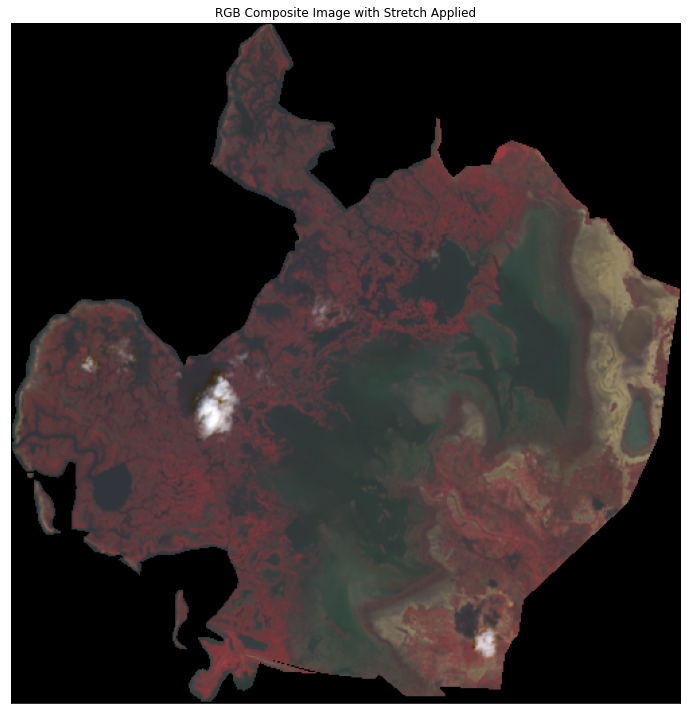

In [106]:
ep.plot_rgb(
    ds.values,
    rgb=(4,3,0),
    stretch=True,
    str_clip=0.01,
    figsize=(12,16),
    title='RGB Composite Image with Stretch Applied',
)

plt.show()

## Preprocessing

In [108]:
x = np.moveaxis(arr_st, 0, -1)
X_data = x.reshape(-1,12)
scaler = StandardScaler().fit(X_data)
X_scaled = scaler.transform(X_data)

#Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data.ravel(),
            test_size=0.3, stratify=y_data.ravel())
print(f"X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}")

NameError: name 'X_Scaled' is not defined